In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [101]:
# Read the Timer Profiling data

# Directory path containing the files
directory = 'data'

# List to store individual DataFrames
dataframes = []

# categories
categories = ["catalyst", "posthocio", "no_sensei"]

# Iterate over each file in the directory
for cat in categories:
    path = os.path.join(directory, cat)
    for filename in os.listdir(path):
        if "Times" in filename and filename.endswith(".csv"):
            ranks = filename.split("-")[-1].split(".")[0]
            file_path = os.path.join(path, filename)
            data = pd.read_csv(file_path)
            data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
            data['total_ranks'] = ranks
            data['category'] = cat
            dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = result['total_ranks'].astype(int)

In [102]:
result.head()

,rank,thread,name,start_time,end_time,delta,bytes,depth,total_ranks,category
0,0,22872455073792,"""CatalystAnalysisAdaptor::Initialize""",1.686930e+09,1.686930e+09,0.061428,-1,3,4,catalyst
1,0,22872455073792,"""CatalystAnalysisAdaptor::0::Initialize""",1.686930e+09,1.686930e+09,0.000002,-1,3,4,catalyst
2,0,22872455073792,"""ConfigurableAnalysis::Initialize""",1.686930e+09,1.686930e+09,4.803490,-1,2,4,catalyst
3,0,22872455073792,"""ConfigurableAnalysis::Initialize""",1.686930e+09,1.686930e+09,4.819723,-1,1,4,catalyst
4,0,22872455073792,"""nek::sensei_bridge::initialize""",1.686930e+09,1.686930e+09,4.819940,-1,0,4,catalyst


# Mean time per timestep

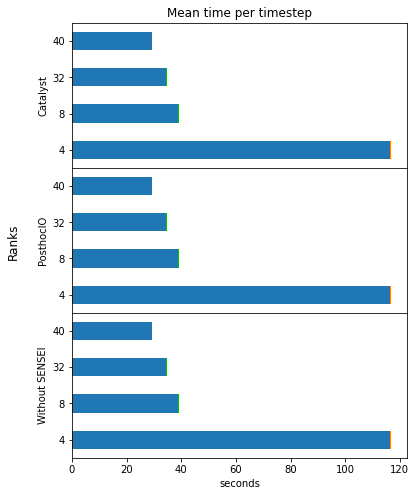

In [113]:
# Group the data by 'name' and 'rank' and calculate the mean 'delta' values for the desired columns
grouped_data = df[result['name'].str.contains('CatalystAnalysisAdaptor::Execute|CatalystAnalysisAdaptor::Initialize|CatalystAnalysisAdaptor::Finalize')]
grouped_data = grouped_data.groupby(['name', 'total_ranks', 'category'])['delta'].mean().reset_index()

catalyst = grouped_data[grouped_data['category'] == 'catalyst']
posthocio = grouped_data[grouped_data['category'] == 'posthocio']
no_sensei = grouped_data[grouped_data['category'] == 'no_sensei']

# Pivot the data to have 'rank' as columns and 'name' as index
catalyst = catalyst.pivot(index='total_ranks', columns='name', values='delta')
posthocio = posthocio.pivot(index='total_ranks', columns='name', values='delta')
no_sensei = no_sensei.pivot(index='total_ranks', columns='name', values='delta')

# Sort the index in ascending order
catalyst.sort_index(ascending=True, inplace=True)
posthocio.sort_index(ascending=True, inplace=True)
no_sensei.sort_index(ascending=True, inplace=True)

fig, axs = plt.subplots(3, figsize=(6,8))

# Plot the stacked bar graph with axes flipped
catalyst.plot(ax=axs[0], kind='barh', stacked=True)
posthocio.plot(ax=axs[1], kind='barh', stacked=True)
no_sensei.plot(ax=axs[2], kind='barh', stacked=True)

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Mean time per timestep')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("PosthocIO")
axs[2].set_ylabel("Without SENSEI")

axs[2].set_xlabel("seconds")

# Show the plot
plt.show()

# Average Memory per rank

In [117]:
dataframes = []
# Iterate over each file in the directory
for cat in categories:
    path = os.path.join(directory, cat)
    for filename in os.listdir(path):
        if "MemProf" in filename and filename.endswith(".csv"):
            ranks = filename.split("-")[-1].split(".")[0]
            file_path = os.path.join(path, filename)
            data = pd.read_csv(file_path)
            data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
            data['total_ranks'] = ranks
            data['category'] = cat
            dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = df['total_ranks'].astype(int)

# Covert to MB
df['memory_mb'] = df['memory_kib'] / 1024

# Covert to GB
df['memory_gb'] = df['memory_mb'] / 1024


In [137]:
df.head()

,rank,time,memory_kib,total_ranks,category,memory_mb,memory_gb
0,0,1.686949e+09,2649668,40,catalyst,2587.566406,2.526920
1,1,1.686949e+09,2633344,40,catalyst,2571.625000,2.511353
2,2,1.686949e+09,2722556,40,catalyst,2658.746094,2.596432
3,3,1.686949e+09,2639480,40,catalyst,2577.617188,2.517204
4,4,1.686949e+09,2668084,40,catalyst,2605.550781,2.544483


Text(0.5, 0, 'memory (GB)')

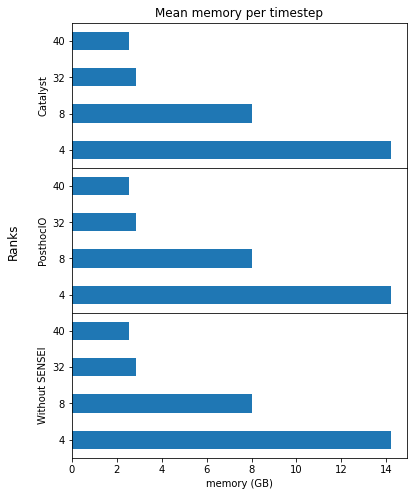

In [135]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = df.groupby(['total_ranks', 'category'])['memory_gb'].mean().reset_index()
catalyst = sum_avg_memory[sum_avg_memory['category'] == 'catalyst']
posthocio = sum_avg_memory[sum_avg_memory['category'] == 'posthocio']
no_sensei = sum_avg_memory[sum_avg_memory['category'] == 'no_sensei']

# Sort the index in ascending order
catalyst.sort_index(ascending=True, inplace=True)
posthocio.sort_index(ascending=True, inplace=True)
no_sensei.sort_index(ascending=True, inplace=True)

fig, axs = plt.subplots(3, figsize=(6,8))

# Plot the stacked bar graph with axes flipped
catalyst.plot(ax=axs[0], kind='barh', x='total_ranks', y='memory_gb')
posthocio.plot(ax=axs[1], kind='barh', x='total_ranks', y='memory_gb')
no_sensei.plot(ax=axs[2], kind='barh', x='total_ranks', y='memory_gb')

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Mean memory per timestep')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("PosthocIO")
axs[2].set_ylabel("Without SENSEI")

axs[2].set_xlabel("memory (GB)")


In [140]:
#XXXX THIS IS INCORRECT

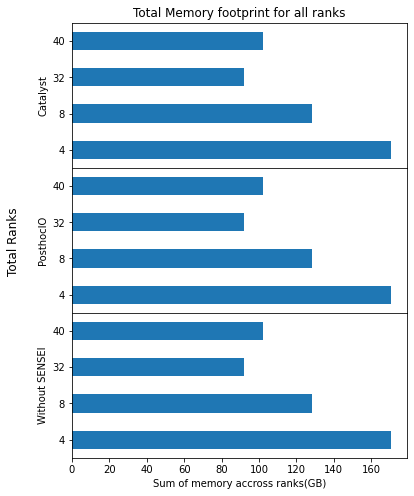

In [139]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = df.groupby(['total_ranks', 'category'])['memory_gb'].sum().reset_index()
catalyst = sum_avg_memory[sum_avg_memory['category'] == 'catalyst']
posthocio = sum_avg_memory[sum_avg_memory['category'] == 'posthocio']
no_sensei = sum_avg_memory[sum_avg_memory['category'] == 'no_sensei']

# Sort the index in ascending order
catalyst.sort_index(ascending=True, inplace=True)
posthocio.sort_index(ascending=True, inplace=True)
no_sensei.sort_index(ascending=True, inplace=True)

fig, axs = plt.subplots(3, figsize=(6,8))

# Plot the stacked bar graph with axes flipped
catalyst.plot(ax=axs[0], kind='barh', x='total_ranks', y='memory_gb')
posthocio.plot(ax=axs[1], kind='barh', x='total_ranks', y='memory_gb')
no_sensei.plot(ax=axs[2], kind='barh', x='total_ranks', y='memory_gb')

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Total Memory footprint for all ranks')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("PosthocIO")
axs[2].set_ylabel("Without SENSEI")

axs[2].set_xlabel("Sum of memory accross ranks(GB)")

# Show the plot
plt.show()

In [111]:
sum_memory = result.groupby(['time', 'total_ranks'])['memory_kib'].sum()

In [119]:
result[result['total_ranks'] == 4]

,rank,time,memory_kib,total_ranks,memory_mb,memory_gb
72,0,1.686930e+09,13401224,4,13087.132812,12.780403
73,0,1.686930e+09,14859736,4,14511.460938,14.171349
74,0,1.686930e+09,16371300,4,15987.597656,15.612888
75,1,1.686930e+09,13439124,4,13124.144531,12.816547
76,1,1.686930e+09,14851880,4,14503.789062,14.163857
77,1,1.686930e+09,16453120,4,16067.500000,15.690918
78,2,1.686930e+09,13404576,4,13090.406250,12.783600
79,2,1.686930e+09,14848208,4,14500.203125,14.160355
80,2,1.686930e+09,16487060,4,16100.644531,15.723286
81,3,1.686930e+09,13448520,4,13133.320312,12.825508


In [160]:
memory_usage = {}
total_ranks = pd.unique(result['total_ranks'])

index = 0
for rank in total_ranks:
    df = result[result['total_ranks'] == rank]
    N = df[df['rank'] == 0].count()['rank']
    res = df['memory_kib'].values.reshape(-1, N)
    total_sum = [sum(x) for x in zip(*res)]

    timestep = 0
    for ts in total_sum:
        memory_usage[str(index)] = {'total_ranks': rank, 'memory_kib': ts, 'timestep': timestep}
        timestep = timestep + 1
        index = index + 1
#memory_usage
memory_df = pd.DataFrame(memory_usage).transpose()
# Covert to MB
memory_df['memory_mb'] = memory_df['memory_kib'] / 1024

# Covert to GB
memory_df['memory_gb'] = memory_df['memory_mb'] / 1024

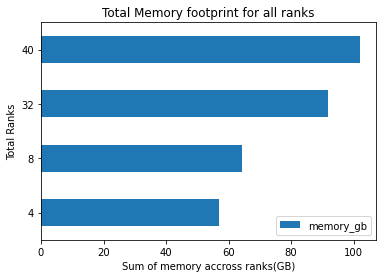

In [164]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = memory_df.groupby('total_ranks')['memory_gb'].mean().reset_index()

# Convert 'Total Ranks' to integers
sum_avg_memory['total_ranks'] = sum_avg_memory['total_ranks'].astype(int)

# Sort the index in ascending order
sum_avg_memory = sum_avg_memory.sort_values('total_ranks')


# Plot the sum of average memory_gb over time by 'total_ranks' with axes flipped
sum_avg_memory.plot(kind='barh', x='total_ranks', y='memory_gb')
#plt.barh()

# Set the title and labels
plt.title('Total Memory footprint for all ranks')
plt.xlabel('Sum of memory accross ranks(GB)')
plt.ylabel('Total Ranks')

# Show the plot
plt.show()

In [165]:
memory_df.groupby('total_ranks')['memory_gb'].mean().reset_index()

,total_ranks,memory_gb
0,4,56.843995
1,8,64.281673
2,32,91.802219
3,40,101.922993
